In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


In [53]:
df = pd.read_csv('../data/processed/amzn_with_sentiment.csv', parse_dates=['Date'])
df.head()


,Date,Close,High,Low,Open,Volume,Return,LogReturn,MA20,Volatility20,SentimentScore
0,NaT,AMZN,AMZN,AMZN,AMZN,AMZN,NaN,NaN,NaN,NaN,0.0
1,2018-01-31,72.54450225830078,73.62899780273438,72.50199890136719,72.56500244140625,128494000,0.009090,0.009049,65.75055,0.009725,1.0
2,2018-02-01,69.5,72.99400329589844,69.25700378417969,72.25,182276000,-0.041967,-0.042873,66.21505,0.015262,-1.0
3,2018-02-02,71.49749755859375,74.9000015258789,70.69999694824219,73.86949920654297,222514000,0.028741,0.028336,66.76595,0.015957,1.0
4,2018-02-05,69.5,72.9489974975586,66.03600311279297,70.13099670410156,229900000,-0.027938,-0.028336,67.16810,0.017811,0.0


In [54]:
from sklearn.preprocessing import MinMaxScaler

# Drop NaNs (no need to touch 'Volume' anymore)
df = df.dropna()

# Define features (without Volume) and target
features = ['LogReturn', 'MA20', 'SentimentScore']
target = 'Volatility20'

# Create two scalers: one for features (X), one for target (y)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale X
X_scaled = feature_scaler.fit_transform(df[features])

# Scale y (notice [[target]] to keep it 2D)
y_scaled = target_scaler.fit_transform(df[[target]])


In [55]:
def create_sequences(X, y, seq_length=20):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y)


In [56]:
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [57]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last output only
        out = self.fc(out)
        return out

model = LSTMModel(input_size=len(features), hidden_size=128, num_layers=3)


In [58]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df[features])
y_scaled = target_scaler.fit_transform(df[[target]])


In [59]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    for X_batch, y_batch in loader:
        output = model(X_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


Epoch 1/100, Loss: 0.0001
Epoch 2/100, Loss: 0.0001
Epoch 3/100, Loss: 0.0001
Epoch 4/100, Loss: 0.0001
Epoch 5/100, Loss: 0.0001
Epoch 6/100, Loss: 0.0001
Epoch 7/100, Loss: 0.0001
Epoch 8/100, Loss: 0.0000
Epoch 9/100, Loss: 0.0001
Epoch 10/100, Loss: 0.0001
Epoch 11/100, Loss: 0.0001
Epoch 12/100, Loss: 0.0001
Epoch 13/100, Loss: 0.0001
Epoch 14/100, Loss: 0.0001
Epoch 15/100, Loss: 0.0001
Epoch 16/100, Loss: 0.0001
Epoch 17/100, Loss: 0.0001
Epoch 18/100, Loss: 0.0001
Epoch 19/100, Loss: 0.0000
Epoch 20/100, Loss: 0.0001
Epoch 21/100, Loss: 0.0001
Epoch 22/100, Loss: 0.0001
Epoch 23/100, Loss: 0.0001
Epoch 24/100, Loss: 0.0001
Epoch 25/100, Loss: 0.0001
Epoch 26/100, Loss: 0.0001
Epoch 27/100, Loss: 0.0001
Epoch 28/100, Loss: 0.0001
Epoch 29/100, Loss: 0.0001
Epoch 30/100, Loss: 0.0000
Epoch 31/100, Loss: 0.0001
Epoch 32/100, Loss: 0.0001
Epoch 33/100, Loss: 0.0001
Epoch 34/100, Loss: 0.0001
Epoch 35/100, Loss: 0.0001
Epoch 36/100, Loss: 0.0000
Epoch 37/100, Loss: 0.0001
Epoch 38/1

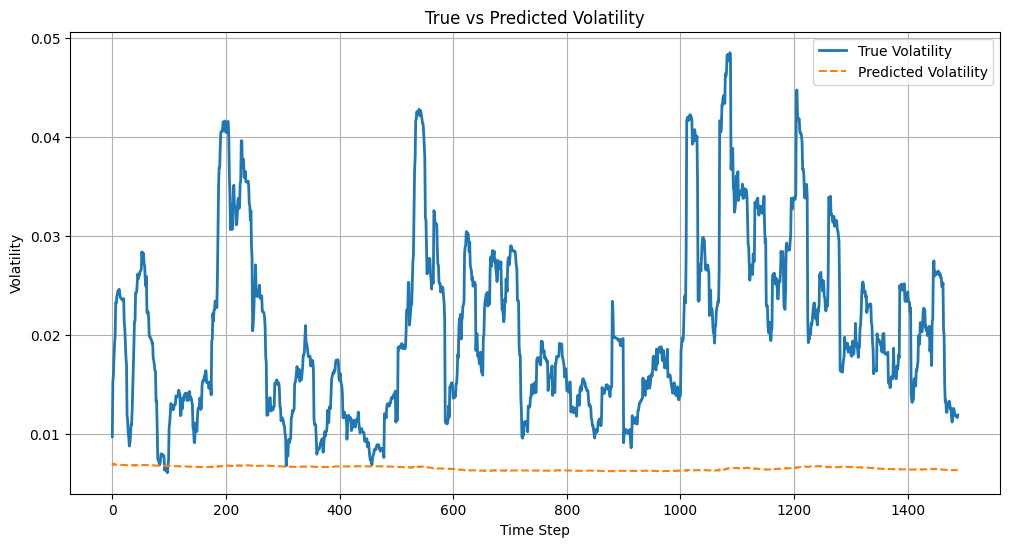

In [61]:
model.eval()

with torch.no_grad():
    predictions_scaled = model(torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1)).numpy()

# Inverse transform predictions back to real-world volatility units
predictions = target_scaler.inverse_transform(predictions_scaled)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(target_scaler.inverse_transform(y_scaled), label='True Volatility', linewidth=2)
plt.plot(predictions, label='Predicted Volatility', linestyle='--')
plt.legend()
plt.title('True vs Predicted Volatility')
plt.xlabel('Time Step')
plt.ylabel('Volatility')
plt.grid()
plt.show()
